# Filter für minimalistische Logos (Balanced Sample)

Dieses Notebook analysiert Logos aus dem balanced_sample Ordner und filtert minimalistische Designs basierend auf:
- Farbkomplexität (Anzahl einzigartiger Farben)
- Kantenkomplexität (Anzahl der Kanten)
- Formkomplexität (Anzahl der Konturen)
- Weißraum-Anteil
- Detailgrad

Minimalistische Logos werden in den Ordner `balanced_sample_filtered` kopiert.

In [1]:
import sys
from pathlib import Path

utils_path = Path('../utils')
sys.path.append(str(utils_path))

from images import (
    analyze_color_complexity,
    analyze_edge_complexity,
    analyze_shape_complexity,
    analyze_whitespace,
    analyze_logo_row
)

In [ ]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import tqdm
import json
import shutil
from parallel_pandas import ParallelPandas

# Pandarallel initialisieren
ParallelPandas.initialize(n_cpu=10)

# Pfade definieren
base_path = Path('../output/amazing_logos_v4')
source_images_path = base_path / 'images' / 'balanced_sample'
filtered_images_path = base_path / 'images' / 'balanced_sample_filtered'
results_path = base_path / 'analysis'

# Ordner erstellen falls nicht vorhanden
filtered_images_path.mkdir(parents=True, exist_ok=True)
results_path.mkdir(exist_ok=True)

print(f"Analysiere Logos in: {source_images_path}")
print(f"Gefilterte minimalistische Logos werden kopiert nach: {filtered_images_path}")

# PNG Dateien aus balanced_sample suchen und DataFrame erstellen
logo_files = list(source_images_path.glob('*.png'))
print(f"Gefunden: {len(logo_files)} Logos")

# DataFrame mit Pfaden erstellen
df_paths = pd.DataFrame({
    'logo_path': logo_files,
    'logo_id': [p.stem for p in logo_files],
    'filename': [p.name for p in logo_files]
})

print(f"DataFrame erstellt mit {len(df_paths)} Einträgen")

Analysiere Logos in: ..\output\amazing_logos_v4\images\balanced_sample
Gefilterte minimalistische Logos werden kopiert nach: ..\output\amazing_logos_v4\images\balanced_sample_filtered
Gefunden: 9925 Logos
DataFrame erstellt mit 9925 Einträgen


## Performance-Optimierung

Dieses Notebook verwendet **pandarallel** um die Analyse zu beschleunigen:

- **pandarallel**: Stabile Parallelisierung mit pandas DataFrames
- **Kernel-sicher**: Funktioniert zuverlässig in Jupyter ohne Kernel-Crashes
- **Progress Bar**: Zeigt automatisch den Fortschritt an
- **Optimal für I/O**: Perfekt für Bildverarbeitung

**Geschätzte Verarbeitungszeit**:
- ~1000 Logos: 2-5 Minuten
- ~3000 Logos: 5-12 Minuten  
- ~10000 Logos: 15-40 Minuten

**Tipps für bessere Performance**:
- Standard 4 Worker sind meist optimal
- Bei mehr RAM können Sie die Worker-Anzahl erhöhen: `pandarallel.initialize(nb_workers=8)`

In [3]:


# Test mit einem Logo
if len(df_paths) > 0:
    test_logo = df_paths.iloc[0]['logo_path']
    print(f"Test mit: {test_logo.name}")
    print("Farbkomplexität:", analyze_color_complexity(test_logo))
    print("Kantenkomplexität:", analyze_edge_complexity(test_logo))
    print("Formkomplexität:", analyze_shape_complexity(test_logo))
    print("Weißraum:", analyze_whitespace(test_logo))

Test mit: amazing_logo_v4000103.png
Farbkomplexität: {'unique_colors': 211, 'dominant_colors': np.int64(3), 'color_variance': np.float64(11570.864403040847)}
Kantenkomplexität: {'edge_pixels': np.int64(1327), 'edge_ratio': np.float64(0.0202484130859375), 'edge_density': np.float64(0.0202484130859375)}
Formkomplexität: {'num_contours': 1, 'total_contour_length': 1020.0, 'largest_contour_complexity': 0.00392156862745098}
Weißraum: {'whitespace_ratio': np.float64(0.7526092529296875), 'content_ratio': np.float64(0.2473907470703125)}
Farbkomplexität: {'unique_colors': 211, 'dominant_colors': np.int64(3), 'color_variance': np.float64(11570.864403040847)}
Kantenkomplexität: {'edge_pixels': np.int64(1327), 'edge_ratio': np.float64(0.0202484130859375), 'edge_density': np.float64(0.0202484130859375)}
Formkomplexität: {'num_contours': 1, 'total_contour_length': 1020.0, 'largest_contour_complexity': 0.00392156862745098}
Weißraum: {'whitespace_ratio': np.float64(0.7526092529296875), 'content_ratio'

In [4]:


# Analyse durchführen mit pandarallel
print("Starte vollständige Analyse mit pandarallel...")
print(f"Analysiere {len(df_paths)} Logos mit paralleler Verarbeitung...")

# Parallel_apply ausführen
analysis_results = df_paths.p_apply(analyze_logo_row, axis=1)

# Basis-DataFrame mit Analyse-Ergebnissen kombinieren
analysis_df = pd.concat([df_paths, analysis_results], axis=1)

print(f"Analyse abgeschlossen: {len(analysis_df)} Logos analysiert")

# Ergebnisse speichern
analysis_df.to_csv(results_path / 'balanced_sample_complexity_analysis.csv', index=False)
print(f"Ergebnisse gespeichert in: {results_path / 'balanced_sample_complexity_analysis.csv'}")

# Erste Statistiken anzeigen
print("\n=== STATISTIKEN ===")
print(analysis_df[['unique_colors', 'dominant_colors', 'edge_ratio', 'num_contours', 'whitespace_ratio']].describe())

Starte vollständige Analyse mit pandarallel...
Analysiere 9925 Logos mit paralleler Verarbeitung...


ANALYZE_LOGO_ROW DONE:   0%|          | 0/9925 [00:00<?, ?it/s]

Analyse abgeschlossen: 9925 Logos analysiert
Ergebnisse gespeichert in: ..\output\amazing_logos_v4\analysis\balanced_sample_complexity_analysis.csv

=== STATISTIKEN ===
       unique_colors  dominant_colors   edge_ratio  num_contours  \
count    9925.000000      9925.000000  9925.000000   9925.000000   
mean     4084.616826         5.298237     0.044448      2.363023   
std      4474.927166         2.867756     0.027083     13.394959   
min        43.000000         1.000000     0.003433      0.000000   
25%      1125.000000         3.000000     0.025742      1.000000   
50%      2681.000000         4.000000     0.037216      1.000000   
75%      5419.000000         8.000000     0.055267      1.000000   
max     48450.000000        10.000000     0.266846    551.000000   

       whitespace_ratio  
count       9925.000000  
mean           0.790851  
std            0.192111  
min            0.000000  
25%            0.734299  
50%            0.851212  
75%            0.918304  
max       

In [5]:
# Minimalismus-Score berechnen
def calculate_minimalism_score(df):
    """Berechnet einen Minimalismus-Score (0-100, höher = minimalistischer)"""
    
    # Normalisierung der Metriken (0-1)
    # Weniger Farben = minimalistischer
    color_score = 1 - (df['dominant_colors'] - df['dominant_colors'].min()) / (df['dominant_colors'].max() - df['dominant_colors'].min() + 1e-8)
    
    # Weniger Kanten = minimalistischer
    edge_score = 1 - (df['edge_ratio'] - df['edge_ratio'].min()) / (df['edge_ratio'].max() - df['edge_ratio'].min() + 1e-8)
    
    # Weniger Konturen = minimalistischer
    contour_score = 1 - (df['num_contours'] - df['num_contours'].min()) / (df['num_contours'].max() - df['num_contours'].min() + 1e-8)
    
    # Mehr Weißraum = minimalistischer
    whitespace_score = (df['whitespace_ratio'] - df['whitespace_ratio'].min()) / (df['whitespace_ratio'].max() - df['whitespace_ratio'].min() + 1e-8)
    
    # Weniger Farbvarianz = minimalistischer
    variance_score = 1 - (df['color_variance'] - df['color_variance'].min()) / (df['color_variance'].max() - df['color_variance'].min() + 1e-8)
    
    # Gewichteter Score
    minimalism_score = (
        color_score * 0.1 +          # 30% Gewicht für Farben
        edge_score * 0.7 +           # 20% Gewicht für Kanten
        contour_score * 0.15 +        # 20% Gewicht für Konturen
        whitespace_score * 0.05 +     # 20% Gewicht für Weißraum
        variance_score * 0.1         # 10% Gewicht für Farbvarianz
    ) * 100
    
    return minimalism_score

# Score berechnen
analysis_df['minimalism_score'] = calculate_minimalism_score(analysis_df)

# Nach Score sortieren
analysis_df_sorted = analysis_df.sort_values('minimalism_score', ascending=False)

print("\n=== TOP 10 MINIMALISTISCHE LOGOS ===")
print(analysis_df_sorted[['logo_id', 'minimalism_score', 'dominant_colors', 'edge_ratio', 'whitespace_ratio']].head(10))

print("\n=== TOP 10 KOMPLEXE LOGOS ===")
print(analysis_df_sorted[['logo_id', 'minimalism_score', 'dominant_colors', 'edge_ratio', 'whitespace_ratio']].tail(10))


=== TOP 10 MINIMALISTISCHE LOGOS ===
                    logo_id  minimalism_score  dominant_colors  edge_ratio  \
6704  amazing_logo_v4264042        109.631240              1.0    0.003433   
3141  amazing_logo_v4120332        108.971715              1.0    0.006149   
2945  amazing_logo_v4112333        108.864586              1.0    0.007187   
8425  amazing_logo_v4335610        108.664092              2.0    0.003922   
5732  amazing_logo_v4224437        108.446585              1.0    0.008682   
8894  amazing_logo_v4357292        108.275905              1.0    0.009430   
1819  amazing_logo_v4067816        108.118350              1.0    0.009628   
1864  amazing_logo_v4069522        108.068807              1.0    0.009766   
9473  amazing_logo_v4380824        107.982256              2.0    0.005249   
2943  amazing_logo_v4112116        107.921551              1.0    0.009293   

      whitespace_ratio  
6704          0.986969  
3141          0.986572  
2945          0.992416  
842

In [6]:
analysis_df_sorted[analysis_df_sorted['logo_id'] == 'logowiz000078']

,logo_path,logo_id,filename,unique_colors,dominant_colors,color_variance,edge_pixels,edge_ratio,edge_density,num_contours,total_contour_length,largest_contour_complexity,whitespace_ratio,content_ratio,minimalism_score


In [7]:
analysis_df_sorted[analysis_df_sorted['logo_id'] == 'logowiz000168']

,logo_path,logo_id,filename,unique_colors,dominant_colors,color_variance,edge_pixels,edge_ratio,edge_density,num_contours,total_contour_length,largest_contour_complexity,whitespace_ratio,content_ratio,minimalism_score


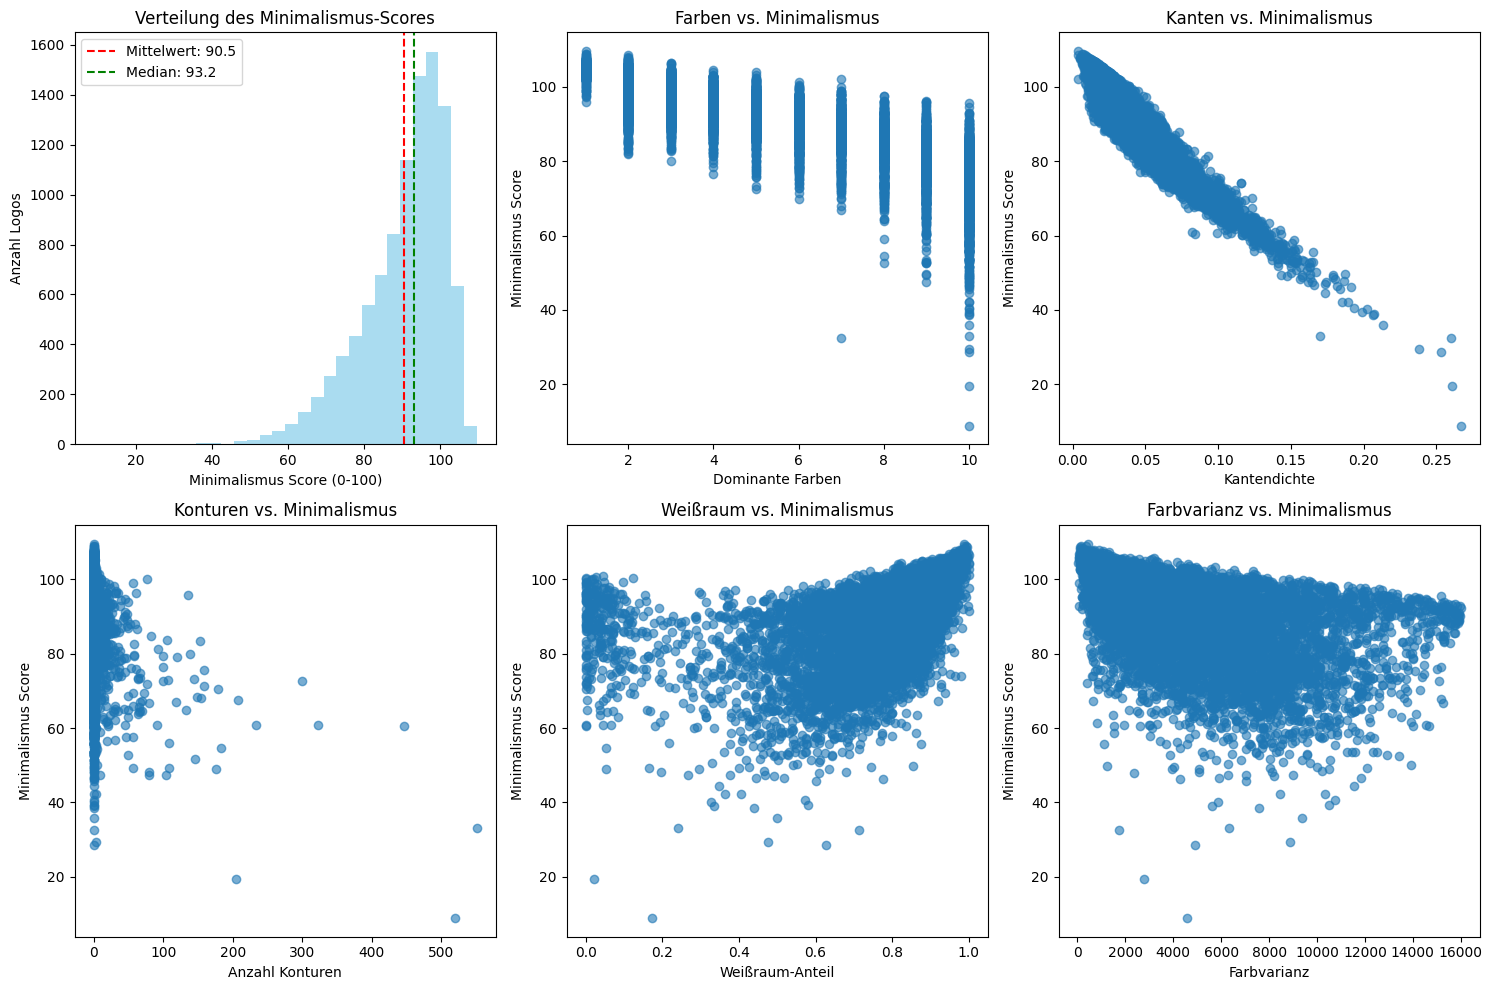

In [8]:
# Minimalismus-Score visualisieren
plt.figure(figsize=(15, 10))

# Score-Verteilung
plt.subplot(2, 3, 1)
plt.hist(analysis_df['minimalism_score'], bins=30, alpha=0.7, color='skyblue')
plt.axvline(analysis_df['minimalism_score'].mean(), color='red', linestyle='--', 
            label=f'Mittelwert: {analysis_df["minimalism_score"].mean():.1f}')
plt.axvline(analysis_df['minimalism_score'].median(), color='green', linestyle='--', 
            label=f'Median: {analysis_df["minimalism_score"].median():.1f}')
plt.title('Verteilung des Minimalismus-Scores')
plt.xlabel('Minimalismus Score (0-100)')
plt.ylabel('Anzahl Logos')
plt.legend()

# Farben vs. Score
plt.subplot(2, 3, 2)
plt.scatter(analysis_df['dominant_colors'], analysis_df['minimalism_score'], alpha=0.6)
plt.xlabel('Dominante Farben')
plt.ylabel('Minimalismus Score')
plt.title('Farben vs. Minimalismus')

# Kanten vs. Score
plt.subplot(2, 3, 3)
plt.scatter(analysis_df['edge_ratio'], analysis_df['minimalism_score'], alpha=0.6)
plt.xlabel('Kantendichte')
plt.ylabel('Minimalismus Score')
plt.title('Kanten vs. Minimalismus')

# Konturen vs. Score
plt.subplot(2, 3, 4)
plt.scatter(analysis_df['num_contours'], analysis_df['minimalism_score'], alpha=0.6)
plt.xlabel('Anzahl Konturen')
plt.ylabel('Minimalismus Score')
plt.title('Konturen vs. Minimalismus')

# Weißraum vs. Score
plt.subplot(2, 3, 5)
plt.scatter(analysis_df['whitespace_ratio'], analysis_df['minimalism_score'], alpha=0.6)
plt.xlabel('Weißraum-Anteil')
plt.ylabel('Minimalismus Score')
plt.title('Weißraum vs. Minimalismus')

# Farbvarianz vs. Score
plt.subplot(2, 3, 6)
plt.scatter(analysis_df['color_variance'], analysis_df['minimalism_score'], alpha=0.6)
plt.xlabel('Farbvarianz')
plt.ylabel('Minimalismus Score')
plt.title('Farbvarianz vs. Minimalismus')

plt.tight_layout()
plt.savefig(results_path / 'balanced_sample_minimalism_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Schwellenwert definieren und minimalistische Logos identifizieren
threshold_percentile = 50  # Obere 50% als minimalistisch
minimalism_threshold = np.percentile(analysis_df['minimalism_score'], threshold_percentile)

print(f"Minimalismus-Schwellenwert ({threshold_percentile}. Perzentil): {minimalism_threshold:.1f}")

# Logos klassifizieren
minimalistic_logos = analysis_df[analysis_df['minimalism_score'] >= minimalism_threshold]
non_minimalistic_logos = analysis_df[analysis_df['minimalism_score'] < minimalism_threshold]

print(f"\n=== KLASSIFIZIERUNG ===")
print(f"Minimalistische Logos: {len(minimalistic_logos)} ({len(minimalistic_logos)/len(analysis_df)*100:.1f}%)")
print(f"Nicht-minimalistische Logos: {len(non_minimalistic_logos)} ({len(non_minimalistic_logos)/len(analysis_df)*100:.1f}%)")

# Listen für Export
minimalistic_ids = minimalistic_logos['logo_id'].tolist()
non_minimalistic_ids = non_minimalistic_logos['logo_id'].tolist()

print(f"\nMinimalistische Logo IDs (erste 10): {minimalistic_ids[:10]}")

Minimalismus-Schwellenwert (50. Perzentil): 93.2

=== KLASSIFIZIERUNG ===
Minimalistische Logos: 4963 (50.0%)
Nicht-minimalistische Logos: 4962 (50.0%)

Minimalistische Logo IDs (erste 10): ['amazing_logo_v4000103', 'amazing_logo_v4000733', 'amazing_logo_v4000782', 'amazing_logo_v4000825', 'amazing_logo_v4000884', 'amazing_logo_v4000999', 'amazing_logo_v4001019', 'amazing_logo_v4001103', 'amazing_logo_v4001198', 'amazing_logo_v4001396']


In [10]:
# Minimalistische Logos in filtered Ordner kopieren
def copy_minimalistic_logos(minimalistic_ids, source_path, target_path, dry_run=True):
    """Kopiert minimalistische Logos in separaten Ordner"""
    
    copied_count = 0
    errors = []
    
    for logo_id in tqdm(minimalistic_ids, desc="Kopiere Logos"):
        source_file = source_path / f"{logo_id}.png"
        target_file = target_path / f"{logo_id}.png"
        
        try:
            if source_file.exists():
                if dry_run:
                    if copied_count < 5:  # Nur erste 5 für Vorschau
                        print(f"[DRY RUN] Würde kopieren: {source_file} -> {target_file}")
                    elif copied_count == 5:
                        print("... (weitere Kopiervorgänge werden nicht angezeigt)")
                else:
                    shutil.copy2(str(source_file), str(target_file))
                    if copied_count < 10:
                        print(f"Kopiert: {logo_id}.png")
                    elif copied_count == 10:
                        print("... (weitere Kopiervorgänge werden nicht angezeigt)")
                
                copied_count += 1
            else:
                errors.append(f"Datei nicht gefunden: {source_file}")
                
        except Exception as e:
            errors.append(f"Fehler bei {logo_id}: {e}")
    
    if dry_run:
        print(f"\n[DRY RUN] Würde insgesamt {copied_count} Logos kopieren")
        print(f"Quelle: {source_path}")
        print(f"Ziel: {target_path}")
        print("\nSetze dry_run=False um tatsächlich zu kopieren")
    else:
        print(f"\n=== KOPIERVORGANG ABGESCHLOSSEN ===")
        print(f"Erfolgreich kopiert: {copied_count} Logos")
        print(f"Fehler: {len(errors)}")
        
        # Überprüfung der Ordner nach Kopiervorgang
        source_count = len(list(source_path.glob('*.png')))
        target_count = len(list(target_path.glob('*.png')))
        print(f"\nNach Kopiervorgang:")
        print(f"Logos in balanced_sample: {source_count}")
        print(f"Logos in balanced_sample_filtered: {target_count}")
    
    if errors:
        print(f"\nFehler ({len(errors)}):")
        for error in errors[:5]:  # Nur erste 5 Fehler anzeigen
            print(f"  - {error}")
        if len(errors) > 5:
            print(f"  ... und {len(errors) - 5} weitere")
    
    return copied_count, errors

# Dry Run - Vorschau des Kopiervorgangs
print("=== DRY RUN - VORSCHAU ===")
copied_count, errors = copy_minimalistic_logos(
    minimalistic_ids, 
    source_images_path, 
    filtered_images_path, 
    dry_run=True
)

=== DRY RUN - VORSCHAU ===


Kopiere Logos: 100%|██████████| 4963/4963 [00:00<00:00, 37099.67it/s]

[DRY RUN] Würde kopieren: ..\output\amazing_logos_v4\images\balanced_sample\amazing_logo_v4000103.png -> ..\output\amazing_logos_v4\images\balanced_sample_filtered\amazing_logo_v4000103.png
[DRY RUN] Würde kopieren: ..\output\amazing_logos_v4\images\balanced_sample\amazing_logo_v4000733.png -> ..\output\amazing_logos_v4\images\balanced_sample_filtered\amazing_logo_v4000733.png
[DRY RUN] Würde kopieren: ..\output\amazing_logos_v4\images\balanced_sample\amazing_logo_v4000782.png -> ..\output\amazing_logos_v4\images\balanced_sample_filtered\amazing_logo_v4000782.png
[DRY RUN] Würde kopieren: ..\output\amazing_logos_v4\images\balanced_sample\amazing_logo_v4000825.png -> ..\output\amazing_logos_v4\images\balanced_sample_filtered\amazing_logo_v4000825.png
[DRY RUN] Würde kopieren: ..\output\amazing_logos_v4\images\balanced_sample\amazing_logo_v4000884.png -> ..\output\amazing_logos_v4\images\balanced_sample_filtered\amazing_logo_v4000884.png
... (weitere Kopiervorgänge werden nicht angezeigt

In [11]:
# Ergebnisse speichern vor dem Kopiervorgang
# Listen als JSON und TXT speichern
with open(results_path / 'balanced_sample_minimalistic_logos.json', 'w') as f:
    json.dump(minimalistic_ids, f, indent=2)

with open(results_path / 'balanced_sample_non_minimalistic_logos.json', 'w') as f:
    json.dump(non_minimalistic_ids, f, indent=2)

with open(results_path / 'balanced_sample_minimalistic_logos.txt', 'w') as f:
    f.write('\n'.join(minimalistic_ids))

with open(results_path / 'balanced_sample_non_minimalistic_logos.txt', 'w') as f:
    f.write('\n'.join(non_minimalistic_ids))

# Detaillierte CSV-Dateien
minimalistic_logos.to_csv(results_path / 'balanced_sample_minimalistic_logos_detailed.csv', index=False)
non_minimalistic_logos.to_csv(results_path / 'balanced_sample_non_minimalistic_logos_detailed.csv', index=False)

print("=== ERGEBNISSE GESPEICHERT ===")
print(f"Dateien in: {results_path}")
print("- balanced_sample_minimalistic_logos.json/txt")
print("- balanced_sample_non_minimalistic_logos.json/txt")
print("- balanced_sample_*_detailed.csv")
print("- balanced_sample_complexity_analysis.csv")
print("- balanced_sample_minimalism_analysis.png")

print("\n=== BEREIT FÜR KOPIERVORGANG ===")
print("Um die minimalistischen Logos tatsächlich zu kopieren,")
print("führe die folgende Zelle aus oder setze dry_run=False in der vorherigen Zelle.")

=== ERGEBNISSE GESPEICHERT ===
Dateien in: ..\output\amazing_logos_v4\analysis
- balanced_sample_minimalistic_logos.json/txt
- balanced_sample_non_minimalistic_logos.json/txt
- balanced_sample_*_detailed.csv
- balanced_sample_complexity_analysis.csv
- balanced_sample_minimalism_analysis.png

=== BEREIT FÜR KOPIERVORGANG ===
Um die minimalistischen Logos tatsächlich zu kopieren,
führe die folgende Zelle aus oder setze dry_run=False in der vorherigen Zelle.


In [12]:
# TATSÄCHLICHER KOPIERVORGANG - Nur ausführen wenn gewünscht!
print("=== WARNUNG: TATSÄCHLICHER KOPIERVORGANG ===")
print(f"Dies wird {len(minimalistic_ids)} Logos kopieren!")
print("Drücke Strg+C zum Abbrechen oder warte 5 Sekunden...")

import time
for i in range(5, 0, -1):
    print(f"Starte in {i} Sekunden...")
    time.sleep(1)

print("\nStarte Kopiervorgang...")
copied_count, errors = copy_minimalistic_logos(
    minimalistic_ids, 
    source_images_path, 
    filtered_images_path, 
    dry_run=False  # ACHTUNG: Echter Kopiervorgang!
)

print("\n=== KOPIERVORGANG ABGESCHLOSSEN ===")
print(f"Der Ordner balanced_sample_filtered enthält jetzt nur minimalistische Logos.")
print(f"Originale Logos bleiben in: {source_images_path}")
print(f"Gefilterte Logos befinden sich in: {filtered_images_path}")

=== WARNUNG: TATSÄCHLICHER KOPIERVORGANG ===
Dies wird 4963 Logos kopieren!
Drücke Strg+C zum Abbrechen oder warte 5 Sekunden...
Starte in 5 Sekunden...
Starte in 4 Sekunden...
Starte in 4 Sekunden...
Starte in 3 Sekunden...
Starte in 3 Sekunden...
Starte in 2 Sekunden...
Starte in 2 Sekunden...
Starte in 1 Sekunden...
Starte in 1 Sekunden...

Starte Kopiervorgang...

Starte Kopiervorgang...


Kopiere Logos:   6%|▌         | 284/4963 [00:00<00:03, 1389.64it/s]

Kopiert: amazing_logo_v4000103.png
Kopiert: amazing_logo_v4000733.png
Kopiert: amazing_logo_v4000782.png
Kopiert: amazing_logo_v4000825.png
Kopiert: amazing_logo_v4000884.png
Kopiert: amazing_logo_v4000999.png
Kopiert: amazing_logo_v4001019.png
Kopiert: amazing_logo_v4001103.png
Kopiert: amazing_logo_v4001198.png
Kopiert: amazing_logo_v4001396.png
... (weitere Kopiervorgänge werden nicht angezeigt)


Kopiere Logos: 100%|██████████| 4963/4963 [00:04<00:00, 1110.40it/s]


=== KOPIERVORGANG ABGESCHLOSSEN ===
Erfolgreich kopiert: 4963 Logos
Fehler: 0

Nach Kopiervorgang:
Logos in balanced_sample: 9925
Logos in balanced_sample_filtered: 4963

=== KOPIERVORGANG ABGESCHLOSSEN ===
Der Ordner balanced_sample_filtered enthält jetzt nur minimalistische Logos.
Originale Logos bleiben in: ..\output\amazing_logos_v4\images\balanced_sample
Gefilterte Logos befinden sich in: ..\output\amazing_logos_v4\images\balanced_sample_filtered
